# Exploratory Data Analysis

## 1. Notebook overview and imports 

To begin our project, this notebook performs an exploratory analysis of the IBM HR Analytics Employee Attrition dataset. We investigate the factors that lead to **attrition**, which represents employees leaving the company (either voluntarily or involuntarily). 

The overall goal is not only to build a predictive model for the target `Attrition`, but to discover specific changes the business could make to reduce it. 

### Why attrition matters

Attrition poses a significant cost to organizations through lost productivity, rehiring expenses, and weakened team morale. If there are ways to help prevent 

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Readability
pd.set_option('display.max_columns', None)
sns.set(style='whitegrid', palette='muted')
plt.rcParams['figure.figsize'] = (10, 6)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## 2. Load and validate data

First, we load the *IBM HR Analytics Employee Attrition & Performance* dataset from the `data/raw/` directory. We verify the dataset was read correctly and perform a basic inspection.

- **Shape**: 1470 rows × 35 columns.
- **Target**: `Attrition`
  -  **Yes** = left the company, **No** = still employed at the time of data collection.
- **Data types**:
    - `int64`: 26 columns — numerical features (`Age`, `MonthlyIncome`, `DistanceFromHome`, ...).
    - `object`: 9 columns — categorical features (`Gender`, `JobRole`, `BusinessTravel`, ...).
- **No null values**:
  - According to `.info()`, there are no missing values in any column. 
  
- Columns requiring attention before modeling
    - Categorical Variables (object dtype):
      - These need to be one-hot encoded before logistic regression, as the model requires all inputs to be numeric.
    - Constant or non-informative columns (to be dropped):
        - `EmployeeNumber`: Identifier. Only one table so not necessary for any merging.
        - `EmployeeCount`: Always 1.
        - `Over18`: Always "Y".
        - `StandardHours`: Always 80. 
    - These will be removed to avoid introducing noise or unnecessary dimensionality.

In [2]:
# Path to raw data
data_path = "../data/raw/original_data.csv"

# Load data
df = pd.read_csv(data_path)

# Basic info
print("Shape of dataset:", df.shape)
display(df.head())
display(df.info())

Shape of dataset: (1470, 35)


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

None

### Column validation 

- All expected columns are confirmed to be present and are correctly named (no spaces, misspellings, etc.).

In [3]:
# List of features in original CSV file
expected_columns = [
    'Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
    'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
    'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
    'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus',
    'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'Over18', 'OverTime',
    'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
    'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
    'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
    'YearsWithCurrManager'
]

# Get actual columns, put into list
actual_columns = list(df.columns)

# Check for unexpected or missing columns by casting lists to set type (no repeats) 
# and using the - operator (here, a logical set subtraction, not algebraic subtraction)
missing_columns = set(expected_columns) - set(actual_columns)
unexpected_columns = set(actual_columns) - set(expected_columns)

# Print results
if not missing_columns and not unexpected_columns:
    print("Column check passed: All expected columns are present.")
else:
    if missing_columns:
        print("Missing columns:", missing_columns)
    if unexpected_columns:
        print("Unexpected columns:", unexpected_columns)


Column check passed: All expected columns are present.


### Drop non-informative columns

- Columns that do not provide meaningful information are removed:
    - `EmployeeNumber`, `EmployeeCount`, `Over18`, `StandardHours`
- Removing these columns at this early stage simplifies the dataset and prevents them from accidentally influencing the data analysis or model. 

In [4]:
# Drop columns that provide no predictive value
columns_to_drop = ['EmployeeCount', 'Over18', 'StandardHours', 'EmployeeNumber']
df.drop(columns=columns_to_drop, inplace=True)

print("Dropped columns:", columns_to_drop)
print("New shape:", df.shape)

Dropped columns: ['EmployeeCount', 'Over18', 'StandardHours', 'EmployeeNumber']
New shape: (1470, 31)


### Export dataset with dropped columns
- Since no further changes will be made in this exploratory notebook, we export the dataset that reflects the dropped columns for use in the next notebook (as `data_01.csv`). 

In [5]:
# Export cleaned DataFrame for use in the next notebook
try:
    df.to_csv('../data/processed/data_01.csv', index=False)
except Exception as e:
    print(f"Error exporting DataFrame: {e}")
else:
    print("Data successfully exported to '../data/processed/data_01.csv'")

Data successfully exported to '../data/processed/data_01.csv'


## 3. Initial data summary

- Numeric features like `MonthlyIncome` and `MonthlyRate` have wide ranges and will require scaling. 
- Categorical features have low to moderate cardinality (max = 9), making them suitable for one-hot encoding.
- Ordinal features (`Education`, `JobLevel`, satisfaction scores) are already numerically encoded and can be used as-is.

In [6]:
display(df.info())

display(df.describe())

unique_counts = df.nunique().sort_values()
print("Unique values per column:")
display(unique_counts)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EnvironmentSatisfaction   1470 non-null   int64 
 9   Gender                    1470 non-null   object
 10  HourlyRate                1470 non-null   int64 
 11  JobInvolvement            1470 non-null   int64 
 12  JobLevel                  1470 non-null   int64 
 13  JobRole                   1470 non-null   object
 14  JobSatisfaction         

None

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,2.721769,65.891156,2.729932,2.063946,2.728571,6502.931293,14313.103401,2.693197,15.209524,3.153741,2.712245,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,403.509100,8.106864,1.024165,1.093082,20.329428,0.711561,1.106940,1.102846,4707.956783,7117.786044,2.498009,3.659938,0.360824,1.081209,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,102.000000,1.000000,1.000000,1.000000,30.000000,1.000000,1.000000,1.000000,1009.000000,2094.000000,0.000000,11.000000,3.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,2.000000,48.000000,2.000000,1.000000,2.000000,2911.000000,8047.000000,1.000000,12.000000,3.000000,2.000000,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,802.000000,7.000000,3.000000,3.000000,66.000000,3.000000,2.000000,3.000000,4919.000000,14235.500000,2.000000,14.000000,3.000000,3.000000,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,4.000000,4.000000,83.750000,3.000000,3.000000,4.000000,8379.000000,20461.500000,4.000000,18.000000,3.000000,4.000000,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,4.000000,100.000000,4.000000,5.000000,4.000000,19999.000000,26999.000000,9.000000,25.000000,4.000000,4.000000,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


Unique values per column:


Attrition                      2
Gender                         2
PerformanceRating              2
OverTime                       2
MaritalStatus                  3
BusinessTravel                 3
Department                     3
JobInvolvement                 4
StockOptionLevel               4
RelationshipSatisfaction       4
EnvironmentSatisfaction        4
WorkLifeBalance                4
JobSatisfaction                4
Education                      5
JobLevel                       5
EducationField                 6
TrainingTimesLastYear          7
JobRole                        9
NumCompaniesWorked            10
PercentSalaryHike             15
YearsSinceLastPromotion       16
YearsWithCurrManager          18
YearsInCurrentRole            19
DistanceFromHome              29
YearsAtCompany                37
TotalWorkingYears             40
Age                           43
HourlyRate                    71
DailyRate                    886
MonthlyIncome               1349
MonthlyRat

### Target variable distribution: `Attrition`

- **83.88%** of employees stayed (`Attrition = No`)
- **16.12%** of employees left (`Attrition = Yes`)

- There is a significant class imbalance - the majority class (non-attrition) dominates the dataset. This can lead to true positives (predicted and actual Attrition = Yes instances) being ignored by the model. 
- To mitigate this, we'll use the `class_weight='balanced'` parameter in models like logistic regression, which adjusts the loss function to penalize misclassifying the minority class more heavily.
- Also, we will use a technique called SMOTE, which oversamples the minority class in a way that does not alter the nature of the data. 

In [7]:
attrition_counts = df['Attrition'].value_counts()
attrition_percent = df['Attrition'].value_counts(normalize=True) * 100

attrition_summary = pd.DataFrame({
    'Count': attrition_counts,
    'Percentage': attrition_percent.round(2)
})

display(attrition_summary)

,Count,Percentage
Attrition,,
No,1233,83.88
Yes,237,16.12


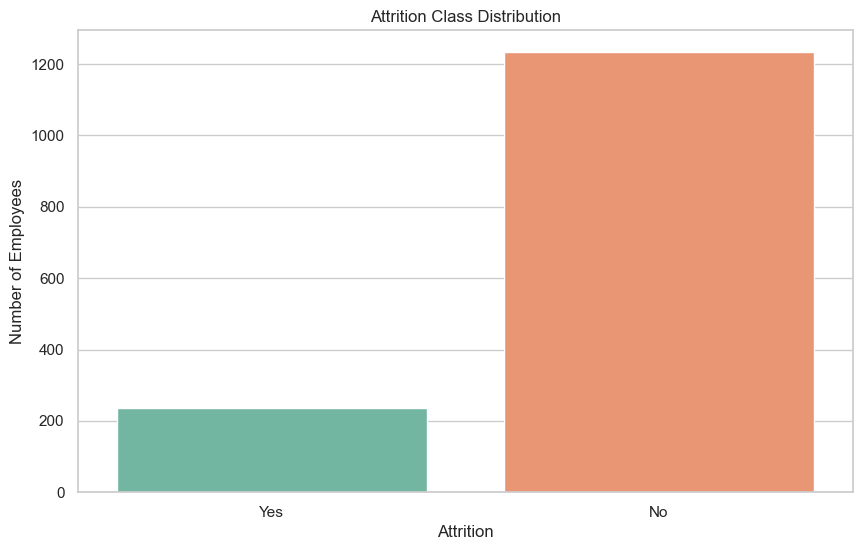

In [8]:
sns.countplot(data=df, x='Attrition', palette='Set2')
plt.title("Attrition Class Distribution")
plt.ylabel("Number of Employees")
plt.xlabel("Attrition")
plt.show()

## 4. Univariate analysis

We analyze the distribution of each feature independently.

- Numeric features: visualized using histograms and boxplots.
- Categorical features: visualized using countplots to show category frequency.

### Numeric features

- Right-skewed distributions are observed in `MonthlyIncome`, `TotalWorkingYears`, `YearsAtCompany`, and `DistanceFromHome`. These may benefit from log transformation to reduce the influence of extreme values.
- Distributions for ordinal features like `Education`, `JobLevel`, `JobInvolvement`, and the various satisfaction scores are clustered around a few discrete integer values. 
  - These represent categorical levels encoded as integers and can be left unscaled.
- Variables such as `YearsSinceLastPromotion`, `YearsWithCurrManager`, and `NumCompaniesWorked` show strong peaks at zero, capturing employees with little prior experience or recent role changes. 
  - These may have nonlinear effects on attrition:
    - For example, the risk of attrition might stay flat for several years, then spike suddenly after a long period without promotion or job change.
- Salary-related variables (`HourlyRate`, `DailyRate`, `MonthlyRate`, `MonthlyIncome`) have varying scales, which can be more easily compared by standardizing their values. 

#### Demographics

- `Age` shows a slightly right-skewed distribution, with most employees between 30 and 40 years old.
- `DistanceFromHome` is heavily right-skewed, indicating that most employees live within 10 km (~ 6.2 miles) of the workplace.
- `Education` is a categorical feature peaking at level 3, with level 5 describing the lowest number of employees.

These features may relate to attrition through commute stress, career stage, or not being properly qualified for the position.

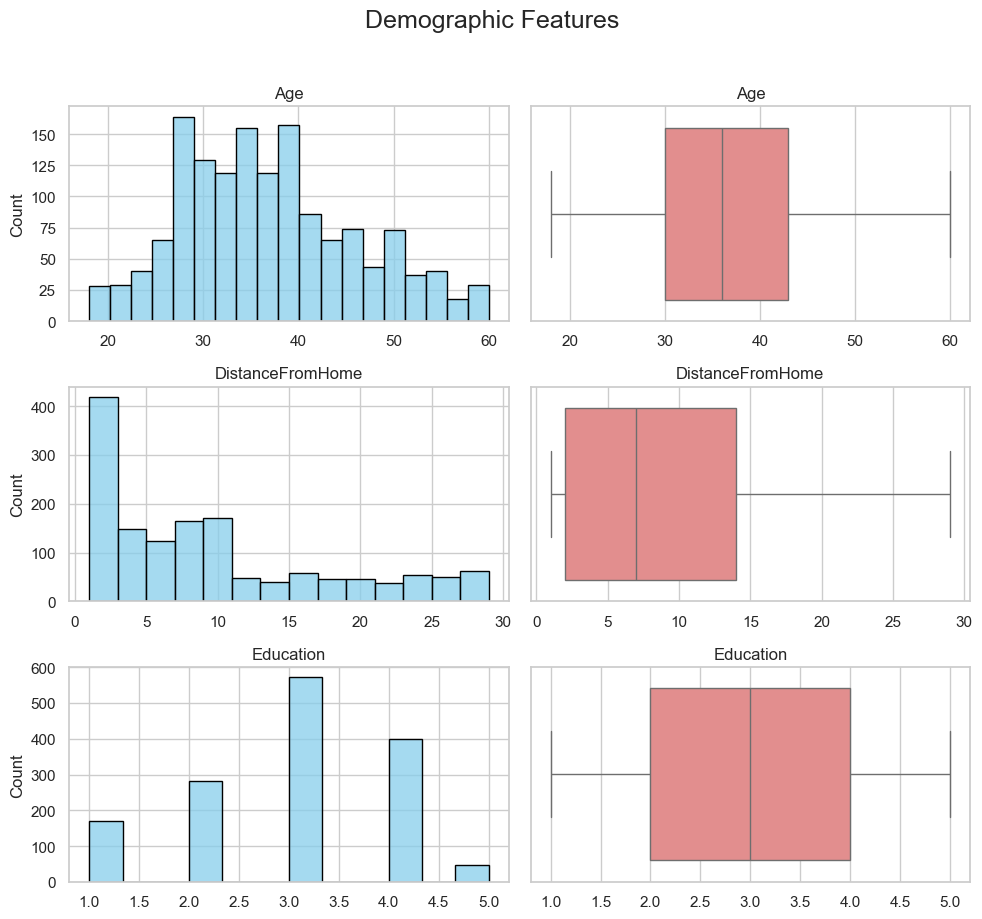

In [9]:
demographics = ['Age', 'DistanceFromHome', 'Education']

fig, axes = plt.subplots(nrows=len(demographics), ncols=2, figsize=(10, len(demographics) * 3))
fig.suptitle('Demographic Features', fontsize=18, y=1.02)

for i, col in enumerate(demographics):
    sns.histplot(data=df, x=col, ax=axes[i, 0], color='skyblue', edgecolor='black')
    axes[i, 0].set_title(f'{col}')
    axes[i, 0].set_xlabel('')

    sns.boxplot(data=df, x=col, ax=axes[i, 1], color='lightcoral')
    axes[i, 1].set_title(f'{col}')
    axes[i, 1].set_xlabel('')

plt.tight_layout()
plt.show()

#### Compensation

> **Note:** Although `StockOptionLevel` is an **ordinal categorical variable** representing discrete levels (0–3), we treat it as numerical here purely for the purpose of visualizing its distribution. For modeling, it should be treated as a categorical feature to avoid implying linear relationships between the levels.
  
- `HourlyRate`, `DailyRate`, and `MonthlyRate` appear uniformly distributed, suggesting limited variability and therefore limited predictive value for modeling.
- `MonthlyIncome` is right-skewed with a long tail and several high outliers, indicating a wide income disparity among employees.
- `PercentSalaryHike` is moderately skewed right, with most employees receiving raises between 11% and 15%.
- `StockOptionLevel` is heavily concentrated at 0 and 1, with relatively few employees receiving higher stock options.
- `JobLevel` is concentrated at levels 1 and 2, implying that most employees are at the lower rungs of the organizational hierarchy.
- `PerformanceRating` is almost entirely at level 3, perhaps due to a lack of variation in evaluations.

While most compensation variables are evenly spread, actual monthly income, percent salary hikes, and stock option levels show more variation — which may reflect underlying compensation policies for organizational rank (`JobLevel`) and/or performance-based incentives (`PerformanceRating`).


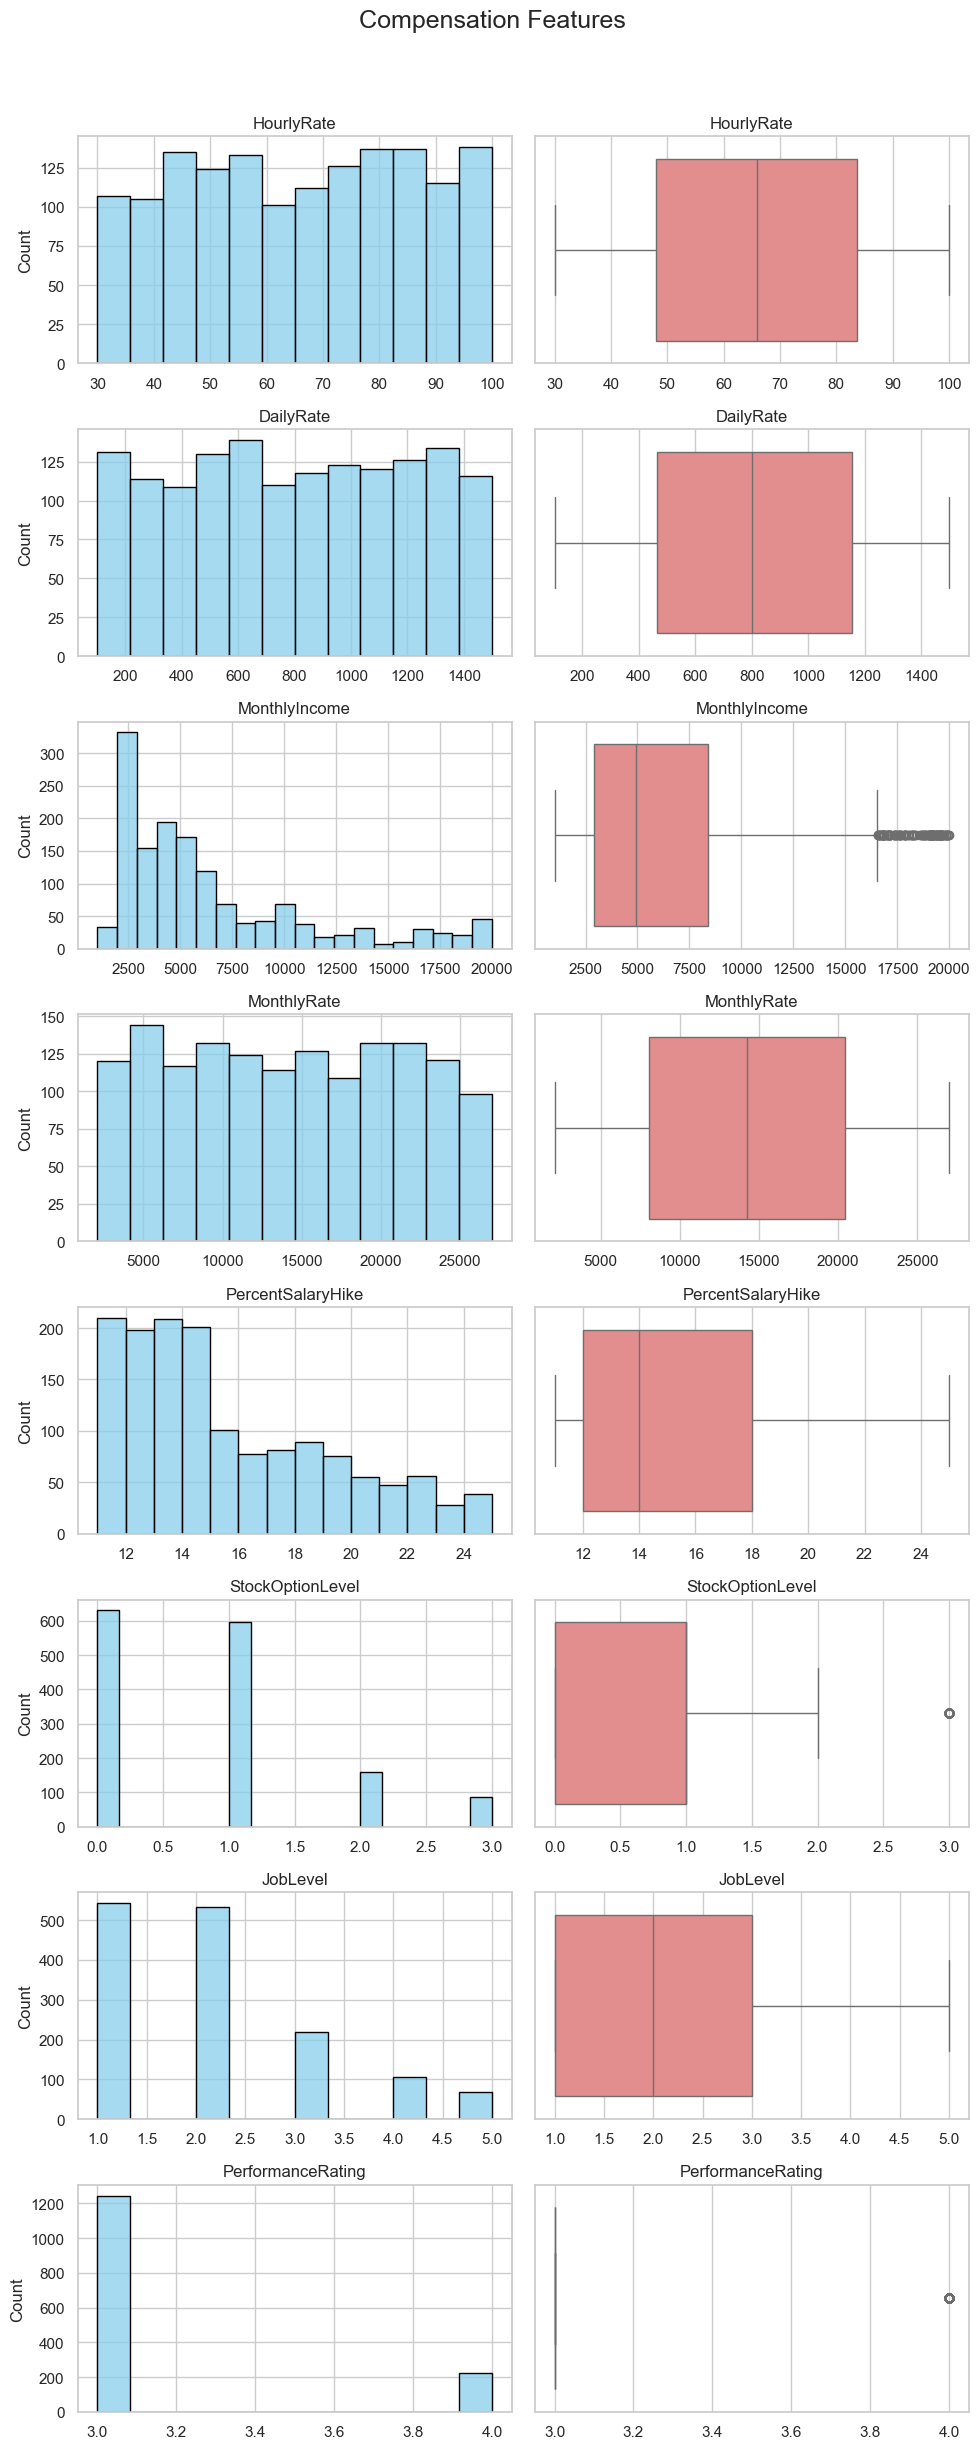

In [10]:
compensation = ['HourlyRate', 'DailyRate', 'MonthlyIncome', 'MonthlyRate', 'PercentSalaryHike', 'StockOptionLevel', 'JobLevel', 'PerformanceRating']

fig, axes = plt.subplots(nrows=len(compensation), ncols=2, figsize=(10, len(compensation) * 3))
fig.suptitle('Compensation Features', fontsize=18, y=1.02)

for i, col in enumerate(compensation):
    sns.histplot(data=df, x=col, ax=axes[i, 0], color='skyblue', edgecolor='black')
    axes[i, 0].set_title(f'{col}')
    axes[i, 0].set_xlabel('') 

    sns.boxplot(data=df, x=col, ax=axes[i, 1], color='lightcoral')
    axes[i, 1].set_title(f'{col}')
    axes[i, 1].set_xlabel('') 

plt.tight_layout()
plt.show()

#### Satisfaction and engagement

- `EnvironmentSatisfaction`, `JobSatisfaction`, and `RelationshipSatisfaction` all have their largest counts at levels 3 and 4, suggesting most employees report moderate to high satisfaction. However, there are also a significant number of instances for the lower two levels for these features, which are possible areas of potential improvement. 
  - `RelationshipSatisfaction` most likely refers to personal relationships (spouse or partner), not interpersonal relationships between employees, although this isn't specified for the dataset. 
- `JobInvolvement` and `WorkLifeBalance` are heavily concentrated at level 3, indicating a generally engaged workforce with a healthy work-life balance, although the number of those reporting levels 1 and 2 is lower but significant.
  
According to the data, most employees feel moderately satisfied and involved, but there is some room for improvement to target the strong minority who report lower levels of these metrics.


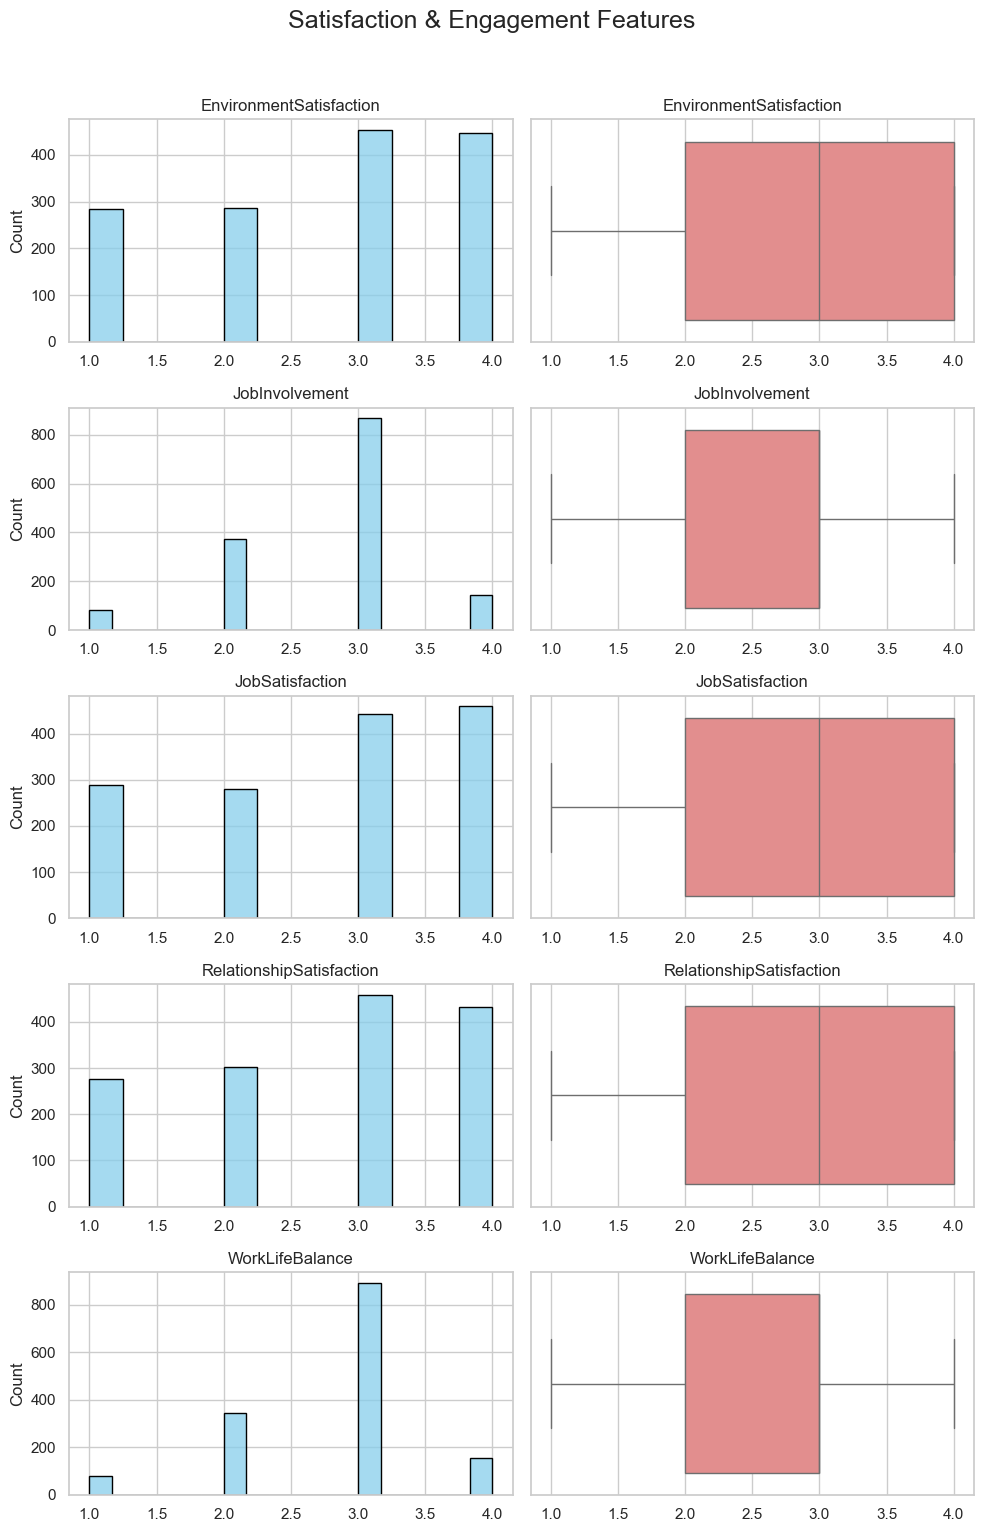

In [11]:
satisfaction = ['EnvironmentSatisfaction', 'JobInvolvement', 'JobSatisfaction', 'RelationshipSatisfaction', 'WorkLifeBalance']

fig, axes = plt.subplots(nrows=len(satisfaction), ncols=2, figsize=(10, len(satisfaction) * 3))
fig.suptitle('Satisfaction & Engagement Features', fontsize=18, y=1.02)

for i, col in enumerate(satisfaction):
    sns.histplot(data=df, x=col, ax=axes[i, 0], color='skyblue', edgecolor='black')
    axes[i, 0].set_title(f'{col}')
    axes[i, 0].set_xlabel('') 

    sns.boxplot(data=df, x=col, ax=axes[i, 1], color='lightcoral')
    axes[i, 1].set_title(f'{col}')
    axes[i, 1].set_xlabel('') 

plt.tight_layout()
plt.show()

#### Tenure and career

- `TotalWorkingYears`, `YearsAtCompany`, and `YearsInCurrentRole` display long right tails, indicating a small group of highly tenured individuals.
  - There is a curious spike at ~ 7.5 years for `YearsInCurrentRole` - perhaps this represents a group that is ripe for a promotion. 
- `TrainingTimesLastYear` shows distinct spikes, most commonly at 2–3 training sessions.
- `YearsSinceLastPromotion` shows mostly recent promotions, though some employees have not been promoted for over a decade.
- `YearsWithCurrManager` shows clustering at low values (around ~ 0 and ~ 2.0), suggesting frequent managerial changes.
  - This distribution is very similar to `YearsInCurrentRole` (showing a similar spike around 7.5 years), pointing out a subset of employees experiencing career stagnation. 
- `NumCompaniesWorked` also has a right-skewed distribution, with many employees having worked at one or two companies, and fewer with broader external experience.

These patterns point to a predominantly early-career workforce with frequent recent promotions and high managerial turnover, though a minority of employees remain in the same roles or under the same managers for extended periods.

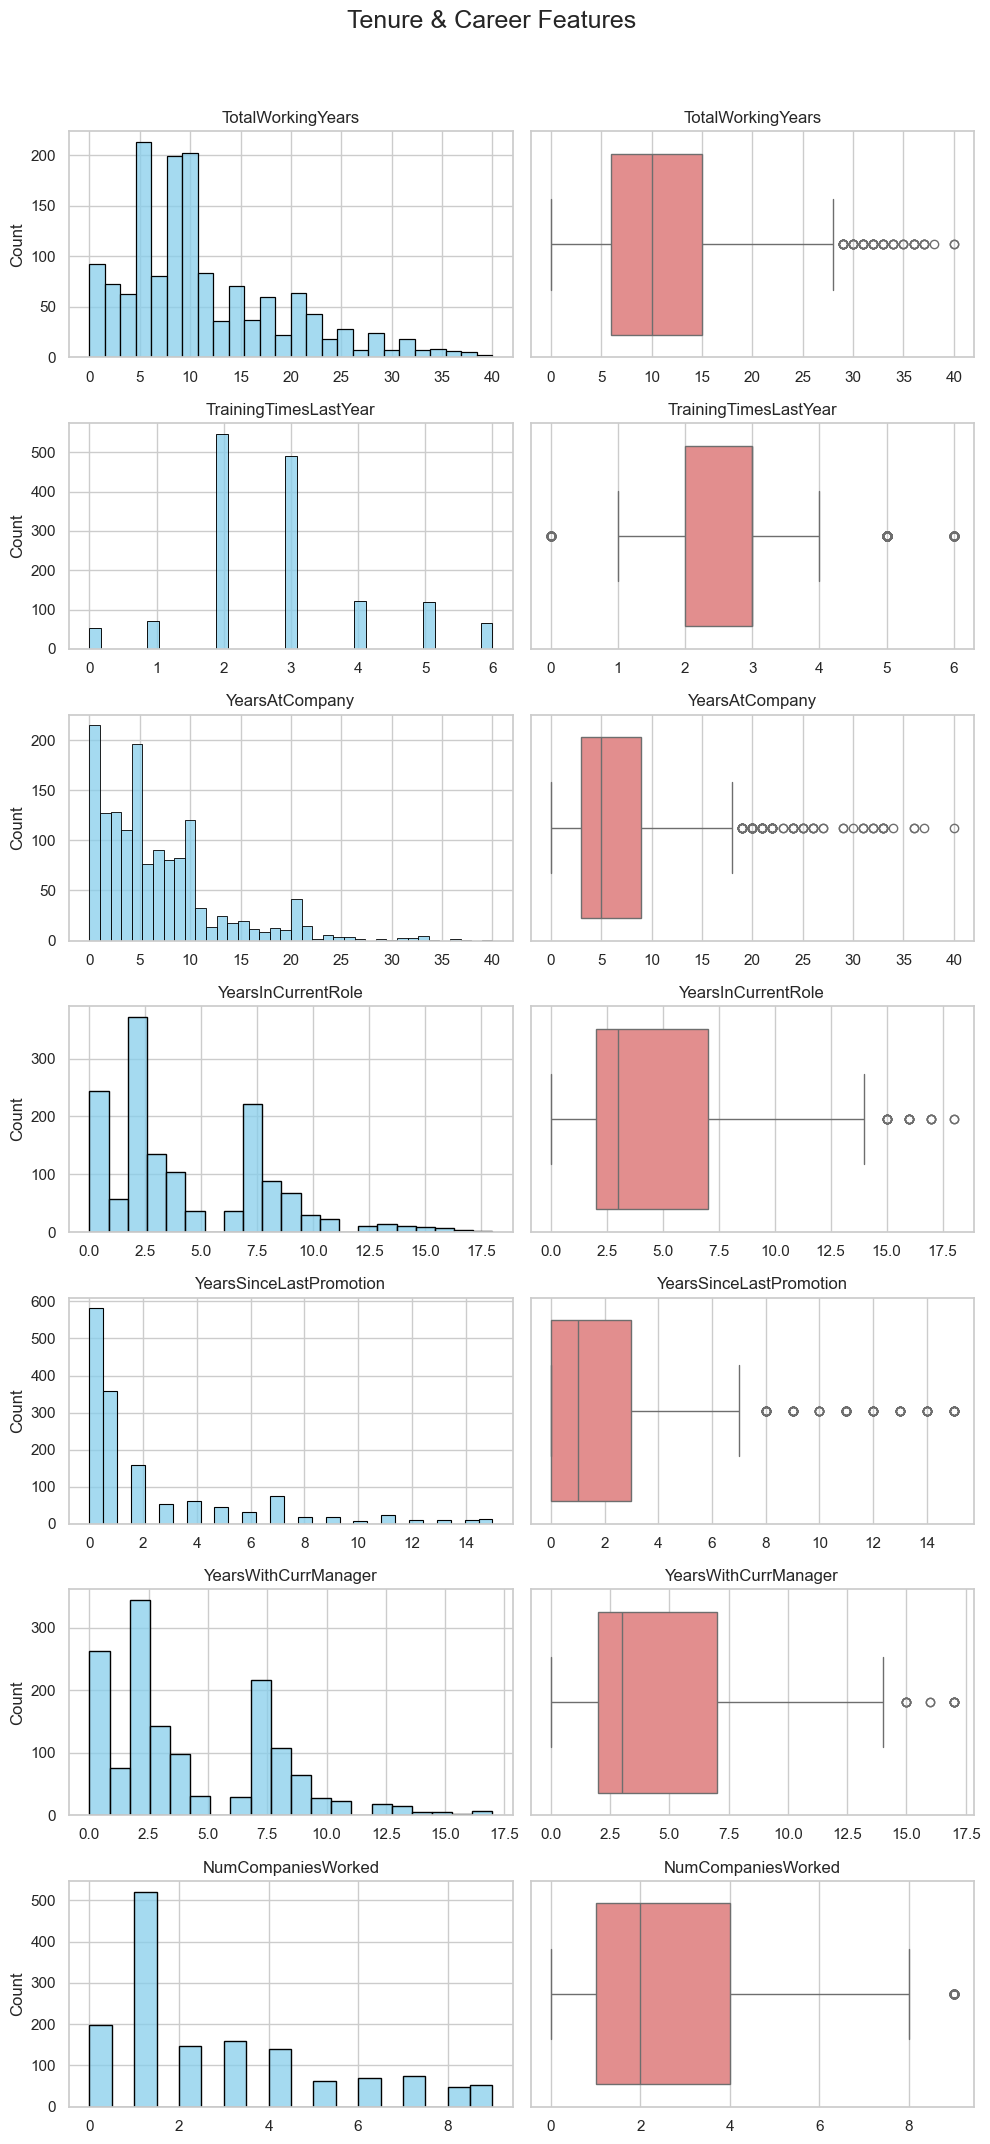

In [12]:
tenure = ['TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'NumCompaniesWorked']

fig, axes = plt.subplots(nrows=len(tenure), ncols=2, figsize=(10, len(tenure) * 3))
fig.suptitle('Tenure & Career Features', fontsize=18, y=1.02)

for i, col in enumerate(tenure):
    sns.histplot(data=df, x=col, ax=axes[i, 0], color='skyblue', edgecolor='black')
    axes[i, 0].set_title(f'{col}')
    axes[i, 0].set_xlabel('')  # Remove x-axis label

    sns.boxplot(data=df, x=col, ax=axes[i, 1], color='lightcoral')
    axes[i, 1].set_title(f'{col}')
    axes[i, 1].set_xlabel('')  # Remove x-axis label

plt.tight_layout()
plt.show()

### Categorical features 

#### Role and department

- `Department` is dominated by employees in `Research & Development`, followed by `Sales`, with very few in `Human Resources`.
- `JobRole` shows that most employees have the titles `Sales Executive`, `Research Scientist`, and `Laboratory Technician`, while there is a lower representation for director or manager-level roles (as one would expect).
  - The disproportionately high number of Sales Executives relative to Sales Representatives may reflect either inflated titling practices or a focus on high-value client relationships over mass lead generation from an abundance of lower-rung employees (cold calling, mass emails, etc.).
- Suprisingly, `EducationField` is concentrated in `Life Sciences` and `Medical`, with other fields such as `Marketing` and `Technical Degree` trailing behind.
  - While IBM is not typically associated with large medical or life sciences teams, this dataset is synthetic and intended for modeling purposes, so the high representation of these education fields likely reflects simulated variety rather than the company's actual workforce.

Overall, the workforce is concentrated in research and sales functions, with a high representation of life sciences and medical educational backgrounds — suggesting the dataset simulates a company involved in scientific or healthcare-related analytics, despite being labeled as IBM.


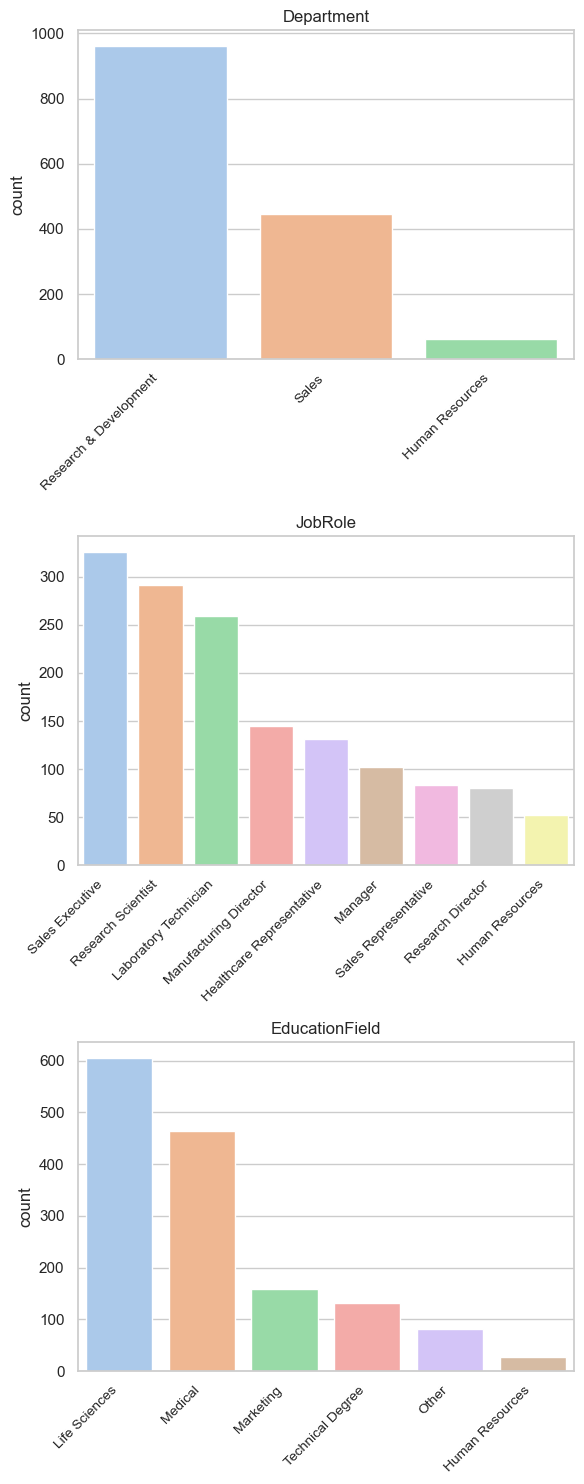

In [13]:
# Bar plots 
cols_role = ['Department', 'JobRole', 'EducationField']

plt.figure(figsize=(6, 15))  
for idx, col in enumerate(cols_role, 1):
    plt.subplot(3, 1, idx)
    sns.countplot(data=df, x=col, palette='pastel', order=df[col].value_counts().index)
    plt.title(col)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.xlabel("") 
    plt.tight_layout()

plt.show()

#### Demographics

- `Gender` shows a roughly 60/40 split between male and female.
- `MaritalStatus` shows that a majority of employees are married, followed by single and divorced individuals.
  - The higher proportion of married employees may correlate with longer tenure (perhaps because of having children).

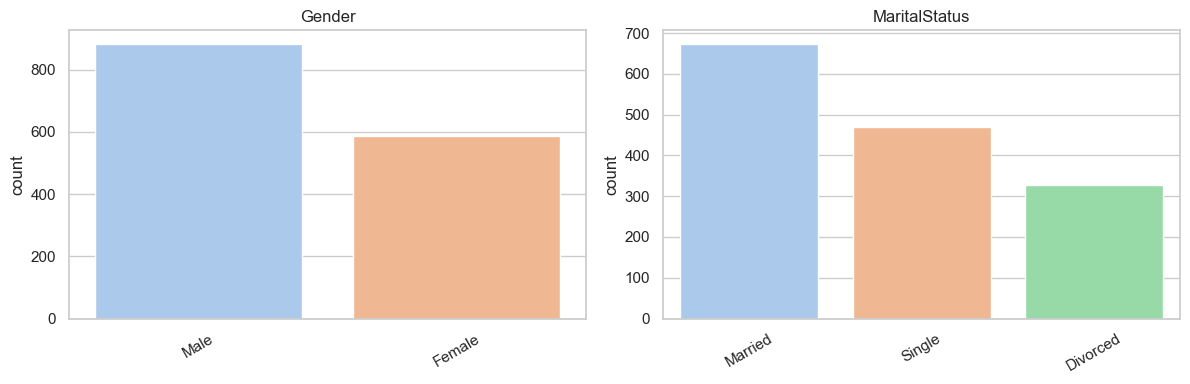

In [14]:
cols_demo = ['Gender', 'MaritalStatus']

plt.figure(figsize=(18, 4))
for idx, col in enumerate(cols_demo, 1):
    plt.subplot(1, 3, idx)
    sns.countplot(data=df, x=col, palette='pastel', order=df[col].value_counts().index)
    plt.title(col)
    plt.xticks(rotation=30)
    plt.xlabel("")
plt.tight_layout()
plt.show()

#### Work pattern

  - `BusinessTravel`: Most employees either travel rarely for business or not at all. Very few travel frequently.
  - `OverTime`: The majority of employees do not work overtime, though a substantial minority does.

The minority of employees who frequently travel or work overtime may suffer from burnout that leads to attrition.

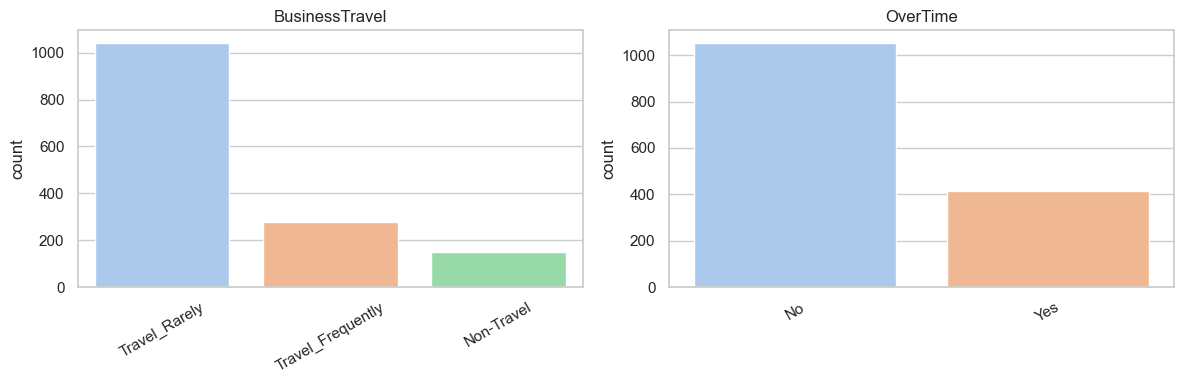

In [15]:
cols_work = ['BusinessTravel', 'OverTime']

plt.figure(figsize=(12, 4))
for idx, col in enumerate(cols_work, 1):
    plt.subplot(1, 2, idx)
    sns.countplot(data=df, x=col, palette='pastel', order=df[col].value_counts().index)
    plt.title(col)
    plt.xticks(rotation=30)
    plt.xlabel("")
plt.tight_layout()
plt.show()

## Affect on attrition

Attrition is most common among (relatively) young employees who earn less, hold lower-level roles, and receive fewer opportunities to grow within the organization. Long commutes and overtime work also appear to contribute significantly to employee attrition. This suggests that concentrating efforts or investment to support employees that may be new to the workforce, and/or those that are required to travel and work long hours, may have a significant impact. 

### Numeric features vs `Attrition`

#### Demographics

- `Age`: Employees who left the company skew younger, with a noticeable peak in the late 20s – early 30s range. Those who stayed are more evenly distributed across older age groups, suggesting that younger employees may be more prone to leave.
- `DistanceFromHome`: There's a wider spread for employees who left, indicating that longer commutes might correlate with higher attrition risk.
- `Education`: Distributions are similar across both groups, implying that education level likely has minimal impact on attrition.

Overall, `Age` and `DistanceFromHome` may be useful predictors, while `Education` appears less relevant.

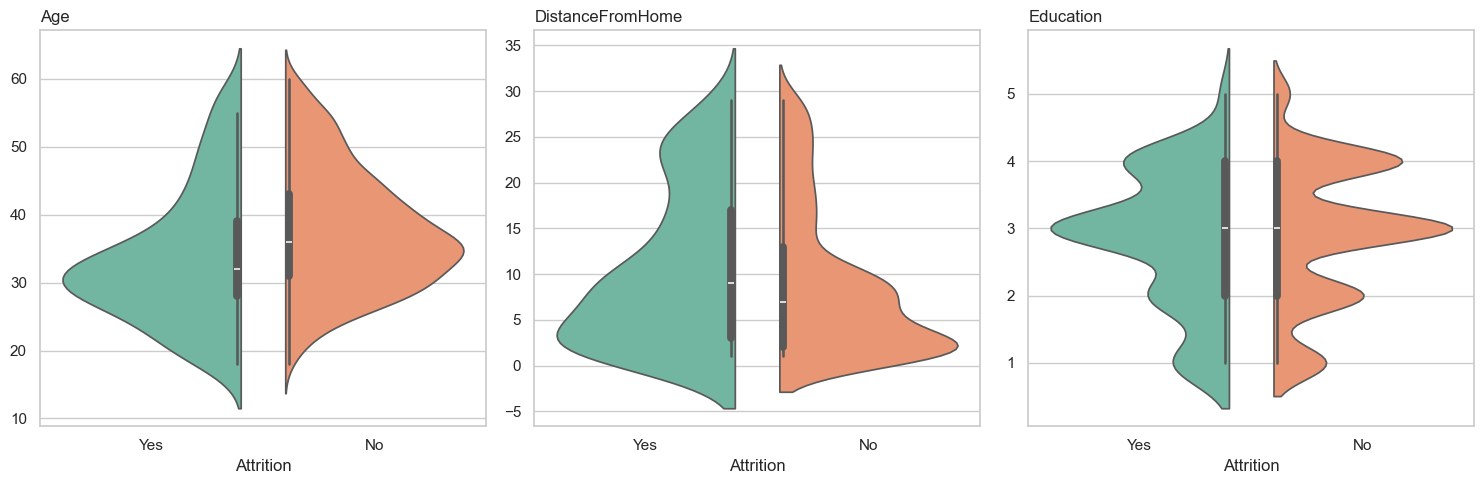

In [16]:
demographics = ['Age', 'DistanceFromHome', 'Education']

plt.figure(figsize=(len(demographics) * 5, 5))
for i, col in enumerate(demographics):
    plt.subplot(1, len(demographics), i+1)
    sns.violinplot(x='Attrition', y=col, data=df, hue='Attrition', split=True, inner='box', palette='Set2', legend=False)
    plt.title(col, loc='left')
    plt.ylabel("")

plt.tight_layout()
plt.show()

#### Compensation

Overall, the plots suggest that compensation structure — especially total monthly income and long-term incentives like stock options — may play a meaningful role in employee attrition risk.

> **Note:** Although `StockOptionLevel` is an **ordinal categorical variable** representing discrete levels (0–3), we treat it as numerical here purely for the purpose of visualizing its distribution. For modeling, it should be treated as a categorical feature to avoid implying linear relationships between the levels.

- `MonthlyIncome`, `DailyRate`: Employees who stayed tend to have higher and more widely distributed incomes. Those who left cluster more tightly around lower income levels. 
  - This may indicate that employees with lower salaries are more likely to leave, which is expected.
- `PercentSalaryHike`: There is a subtle difference where retained employees received slightly more frequent or higher salary hikes. 
  - Although the difference is modest, a small cumulative effect over time might influence retention.
- `StockOptionLevel`: Employees who stayed had slightly more presence at higher stock option levels. 
  - This may reflect better long-term incentives provided to retained employees, suggesting stock options could act as a retention booster.
- Other compensation variables like `HourlyRate`, and `MonthlyRate` do not show strong separation, suggesting they may be less influential or redundant with `MonthlyIncome`.

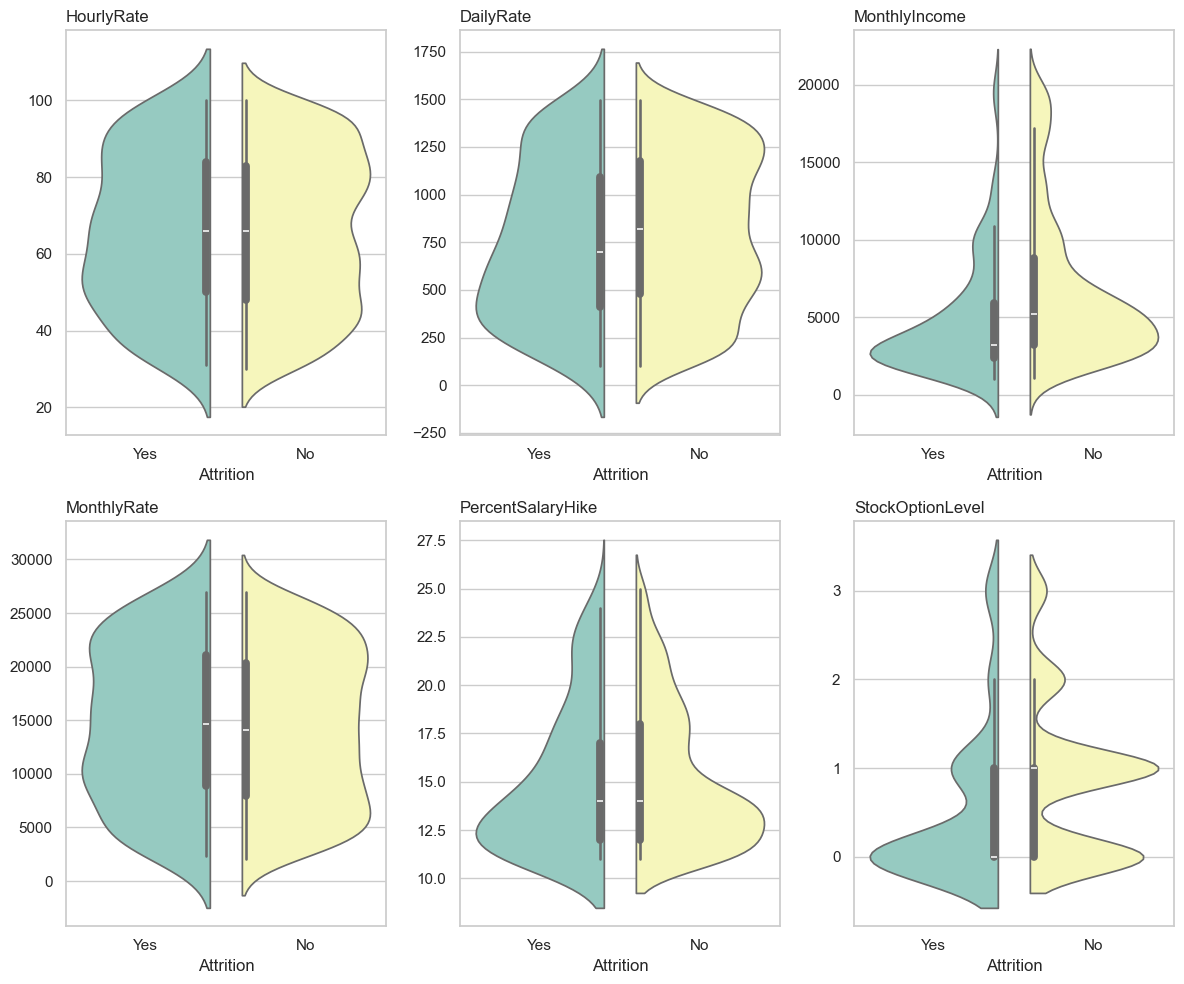

In [17]:
compensation = [
    'HourlyRate', 'DailyRate', 'MonthlyIncome', 'MonthlyRate', 'PercentSalaryHike', 'StockOptionLevel']

n_cols = 3
n_rows = (len(compensation) + n_cols - 1) // n_cols

plt.figure(figsize=(n_cols * 4, n_rows * 5))
for i, col in enumerate(compensation):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.violinplot(x='Attrition', y=col, data=df, hue='Attrition', split=True,
                   inner='box', palette='Set3', legend=False)
    plt.title(col, loc='left')
    plt.ylabel("")

plt.tight_layout()
plt.show()

#### Tenure and career 

These patterns suggest that attrition is more common among employees with shorter tenure, fewer internal promotions, and more prior employers.

- `TotalWorkingYears`, `YearsAtCompany`, `YearsInCurrentRole`, and `YearsWithCurrManager` are all lower on average for those who left, indicating that shorter tenures are associated with higher attrition risk. This may reflect a lack of long-term engagement or low satisfaction early in term of employment. 
- `YearsSinceLastPromotion` shows minimal difference between attrition groups, indicating that promotion timing alone may not be a significant driver of employee turnover.
- `NumCompaniesWorked`: while employees who left include a more instances indicating many prior employers (indicated by the fatter tail towards higher values), their median NumCompaniesWorked is lower than that of those who stayed, suggesting that attrition may also be common among employees with limited prior experience.
- `TrainingTimesLastYear`: Employees who left tend to receive slightly less training than those who stayed, with fewer individuals receiving 3 or more sessions. This may reflect a subtle link between lower development investment and attrition risk.

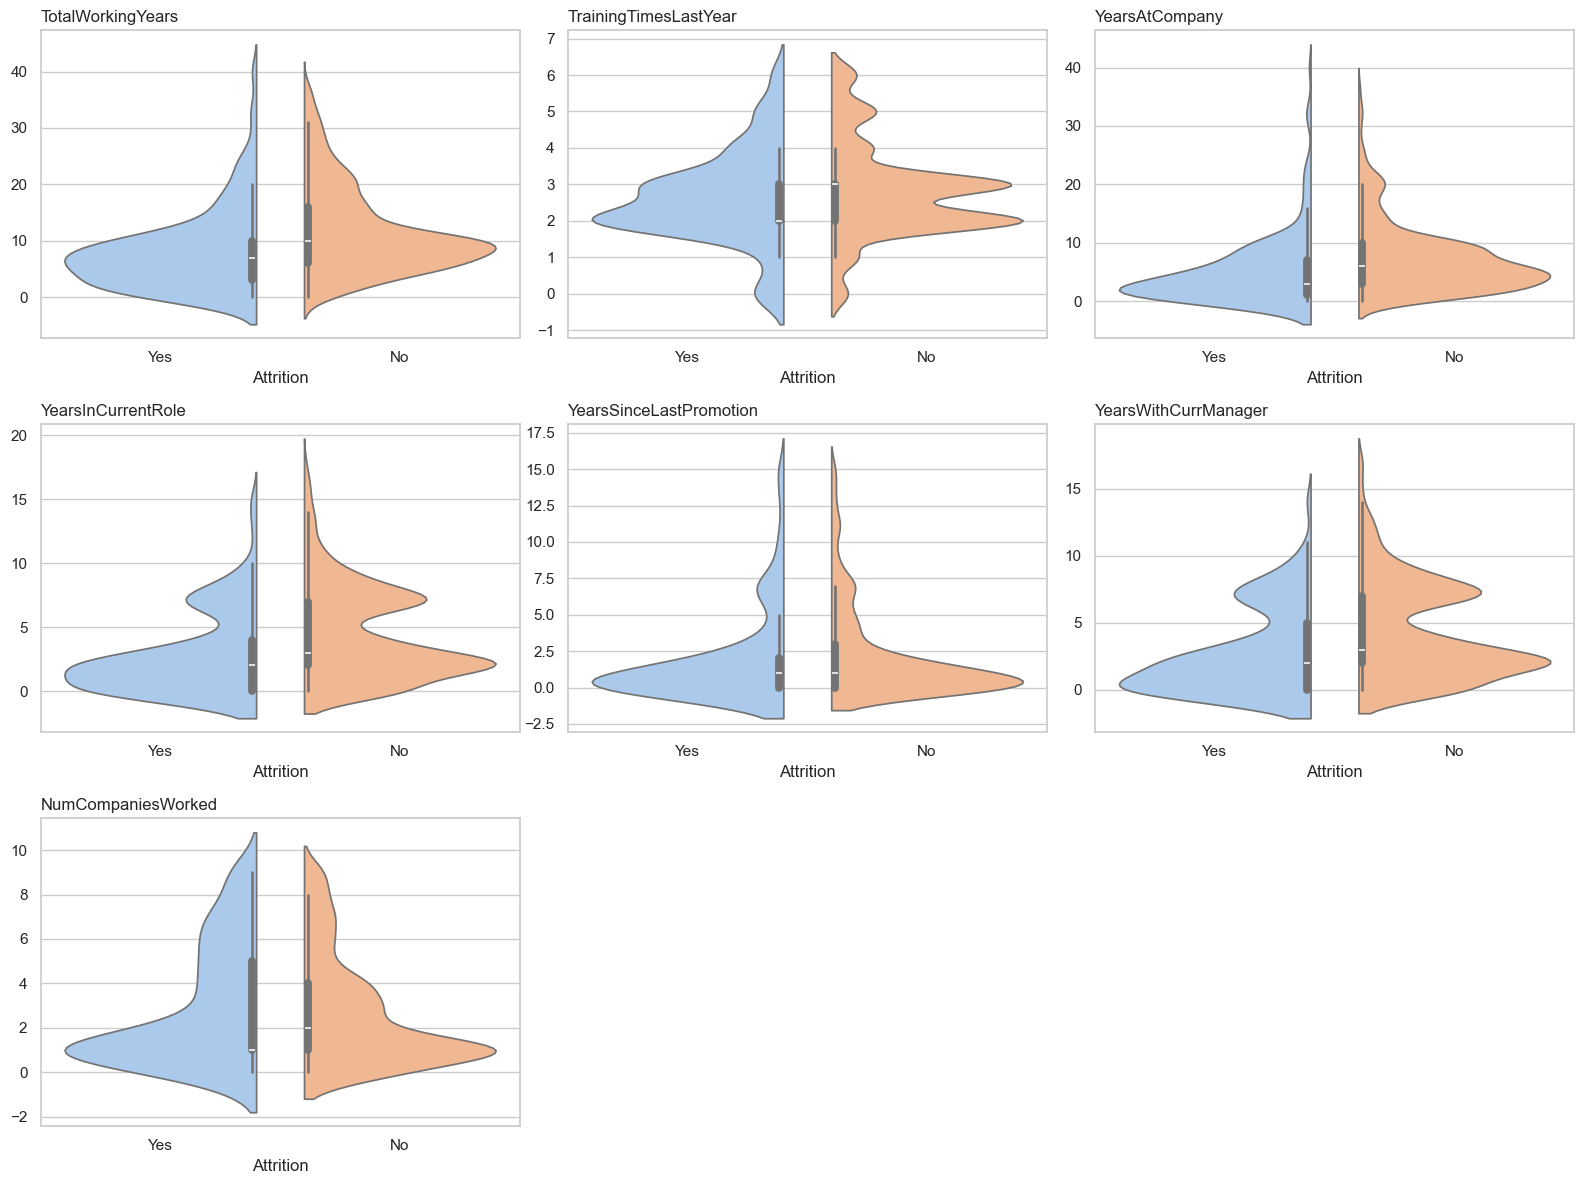

In [18]:
tenure = ['TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'NumCompaniesWorked']

fig, axes = plt.subplots(3, 3, figsize=(16, 12))
axes = axes.flatten()  

for i, col in enumerate(tenure):
    sns.violinplot(
        x='Attrition', y=col, data=df,
        hue='Attrition', split=True, inner='box',
        palette='pastel', legend=False, ax=axes[i]
    )
    axes[i].set_title(col, loc='left')
    axes[i].set_ylabel("")

# Hide the unused last two subplots
for j in range(len(tenure), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

##### Satisfaction and engagement
  
While not all variables show strong separation, `JobSatisfaction`, `EnvironmentSatisfaction`, `WorkLifeBalance`, and `JobLevel` stand out as having visually apparent associations with attrition. 

> **NOTE**: While most features shown are ordinal categorical (`JobSatisfaction`, `WorkLifeBalance`, etc), they are treated here as quasi-continuous solely to aid visual exploration of distributions.

- `EnvironmentSatisfaction`: Employees who stayed tend to report higher environmental satisfaction compared to those who left.
- `JobInvolvement`: Difference is minimal.
- `JobLevel`: Attrition appears more common among employees at lower job levels (especially level 1), while those in higher positions tend to stay.
- `JobSatisfaction`: A higher proportion of employees with low satisfaction left the company, indicating a clear link between job satisfaction and attrition.
- `PerformanceRating`: This feature appears largely uniform across attrition groups.
- `RelationshipSatisfaction`: Employees with lower relationship satisfaction scores are slightly more represented among those who left.
- `WorkLifeBalance`: Attrition is more concentrated among employees who rated their work-life balance poorly (level 1 or 2).

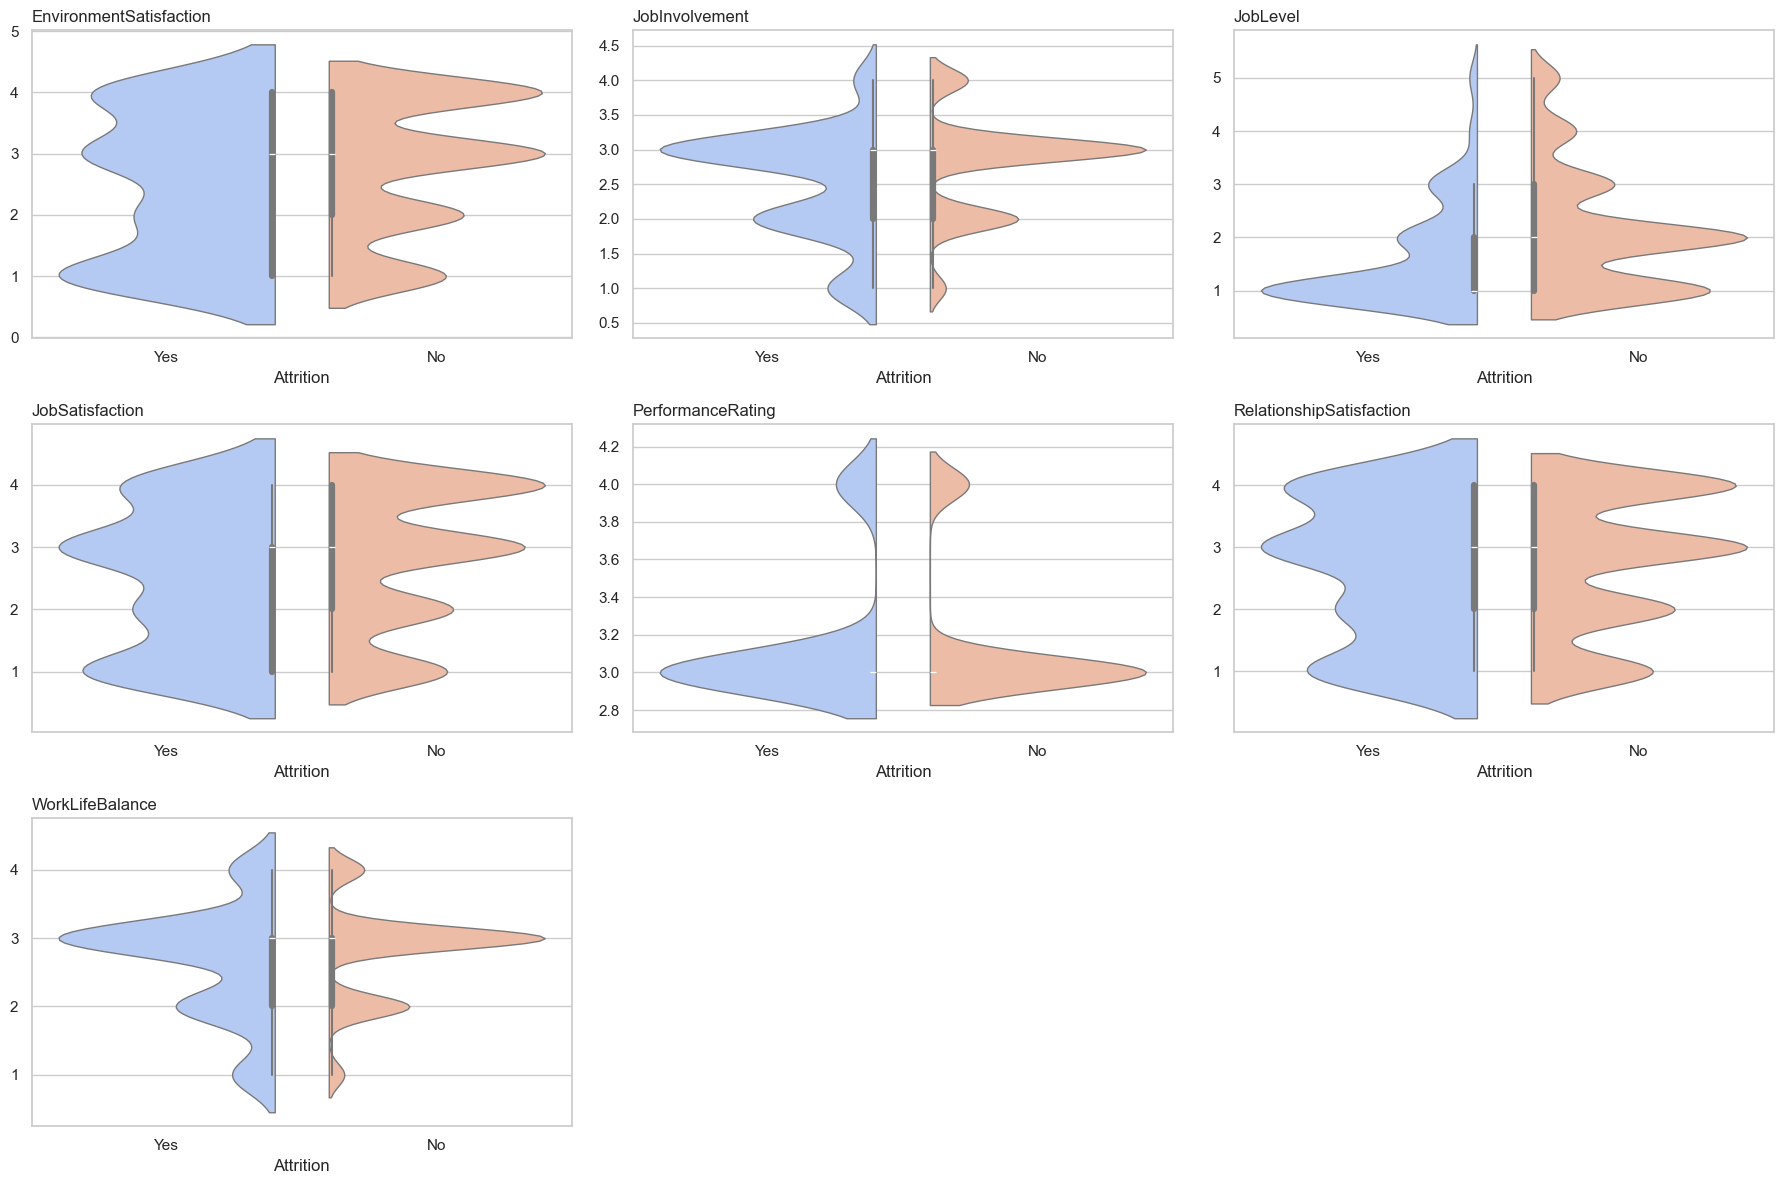

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

satisfaction = ['EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'PerformanceRating', 'RelationshipSatisfaction', 'WorkLifeBalance']

fig, axes = plt.subplots(3, 3, figsize=(18, 12)) 
axes = axes.flatten() 

for i, col in enumerate(satisfaction):
    sns.violinplot(
        x='Attrition',
        y=col,
        data=df,
        hue='Attrition',
        split=True,
        inner='box',
        palette='coolwarm',
        linewidth=1,
        ax=axes[i]
    )
    axes[i].set_title(col, loc='left')
    axes[i].set_ylabel("")
    

# Turn off unused subplots
for j in range(len(satisfaction), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

### Categorical features vs Attrition

#### Role and department breakdown

- Department
  - Attrition is highest in Sales and Human Resources, suggesting these departments may involve higher stress or lower engagement, while Research & Development shows stronger retention, likely due to more specialized, stable roles.
- Job role
  - Sales Representatives and Lab Technicians face the steepest attrition, highlighting a potential need for better support or career development in high-turnover roles, whereas leadership and research positions demonstrate strong retention.
- Education
  - Attrition is higher among employees with backgrounds in Human Resources, Marketing, and Technical Degrees, which may reflect dissatisfaction within those roles, while fields like Life Sciences and Medical show stronger retention, possibly due to better support from the organization and alignment of education and job expectations.

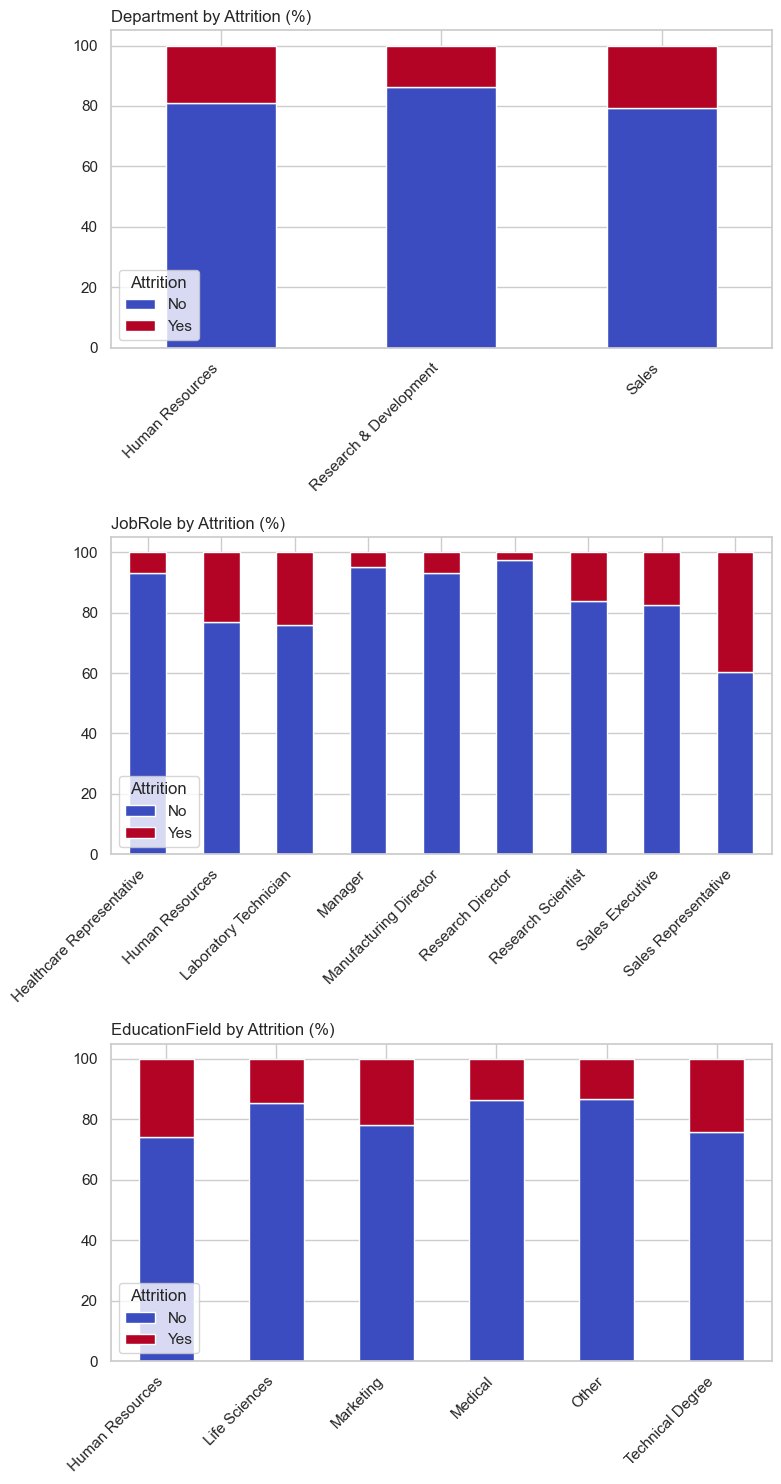

In [20]:
cols_role = ['Department', 'JobRole', 'EducationField']

fig, axes = plt.subplots(len(cols_role), 1, figsize=(8, 15))  

for idx, col in enumerate(cols_role):
    cross_tab = pd.crosstab(df[col], df['Attrition'], normalize='index') * 100
    cross_tab.plot(kind='bar', stacked=True, colormap='coolwarm', ax=axes[idx])
    
    axes[idx].set_title(f'{col} by Attrition (%)', loc='left')
    axes[idx].set_xlabel("")
    axes[idx].set_ylabel("")
    axes[idx].tick_params(axis='x', rotation=45)
    
    for label in axes[idx].get_xticklabels():
        label.set_ha('right')
    
    axes[idx].legend(title='Attrition', loc='lower left')

plt.tight_layout()
plt.show()

#### Demographics

- `Gender` shows little predictive value, with similar attrition rates across males and females.
- `MaritalStatus`, however, reveals that single employees are significantly more likely to leave, perhaps reflecting differences in financial stability or lifestyle priorities (such as having children).

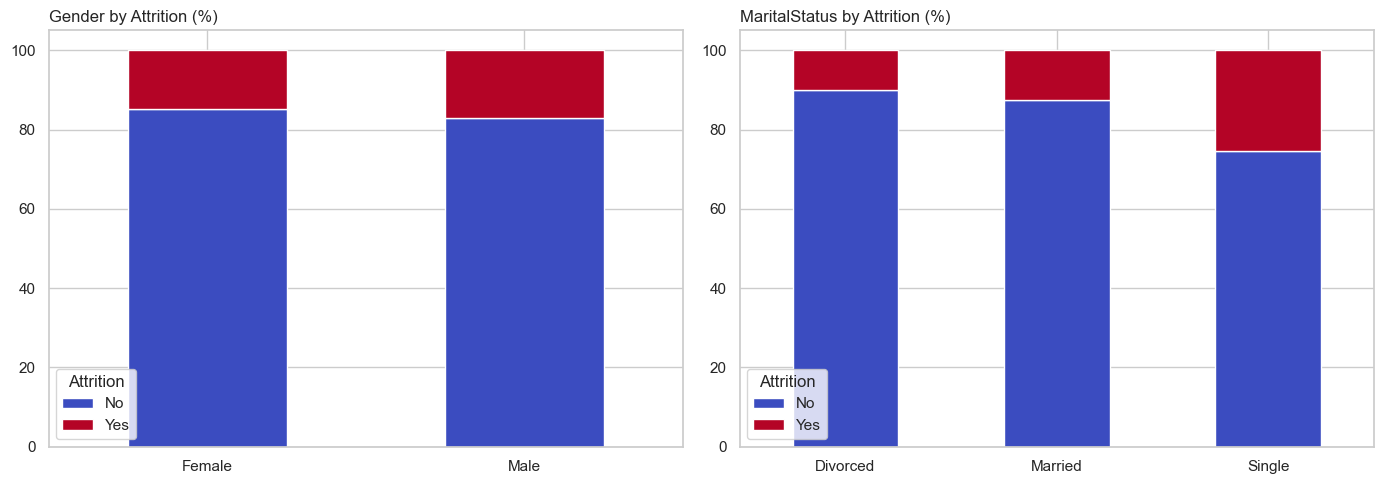

In [21]:
cols_demo = ['Gender', 'MaritalStatus']

fig, axes = plt.subplots(1, len(cols_demo), figsize=(14, 5))

for idx, col in enumerate(cols_demo):
    cross_tab = pd.crosstab(df[col], df['Attrition'], normalize='index') * 100
    cross_tab.plot(kind='bar', stacked=True, colormap='coolwarm', ax=axes[idx])
    axes[idx].set_title(f'{col} by Attrition (%)', loc='left')
    axes[idx].set_xlabel("")
    axes[idx].set_ylabel("")
    axes[idx].tick_params(axis='x', rotation=0) 
    axes[idx].legend(title='Attrition', loc='lower left')  

plt.tight_layout()
plt.show()

#### Work pattern and attrition

- `BusinessTravel`: Employees who travel frequently show significantly higher attrition rates. Those who travel rarely have lower rates, and non-travel employees show the lowest rate. There is a clear positive relationship between the amount of travel and attrition rate. 
- `OverTime`: There is a huge increase in attrition among employees who work overtime, reinforcing the idea that excessive workload contributes to dissatisfaction and departure.
- `JobLevel`: Generally, attrition decreases as job level increases. Entry-level employees (`JobLevel` = 1) show the highest attrition, while mid to senior levels (3–5) show better retention. There is a rise in attrition at job level 3 which slightly disrupts this trend, warranting further investigation of the specific conditions of employment at this level. 
- `StockOptionLevel`: Employees with no stock options (0) have the highest attrition. Those with stock options at levels 1 to 3 show lower attrition, suggesting that equity incentives may help with retention. Notably, `StockOptionLevel` 3 has worse retention than levels 1 and 2. 
 
Employees with heavy travel or overtime demands face much higher attrition - a possible reflection of poor work-life balance.
Lower job levels and minimal stock options are also linked to higher attrition, suggesting that advancement and long-term incentives play a key role in retention.

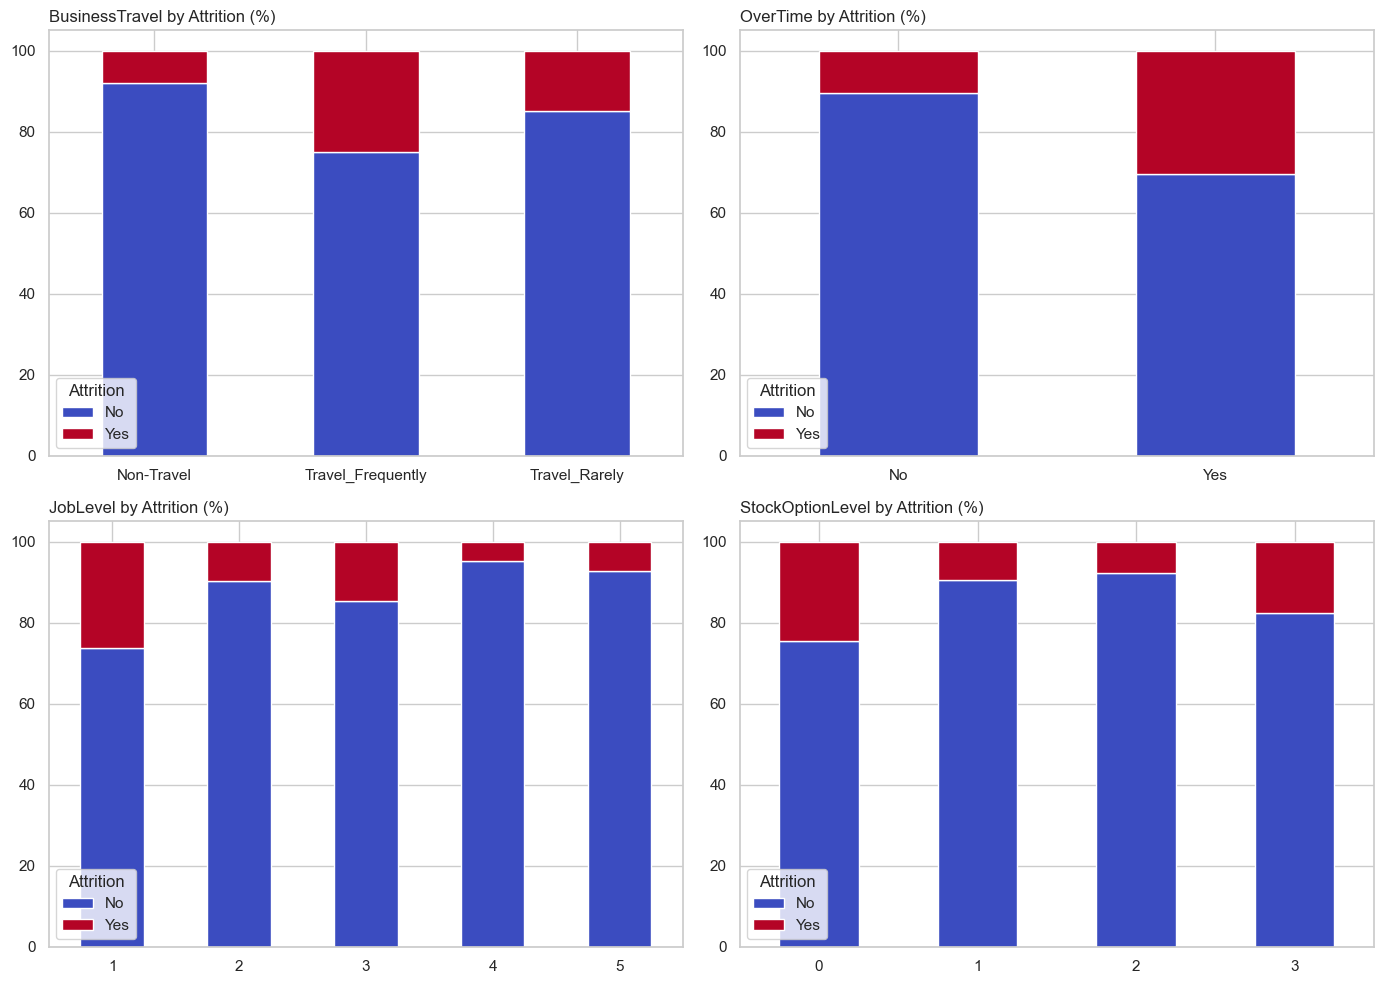

In [22]:
cols_work = ['BusinessTravel', 'OverTime', 'JobLevel', 'StockOptionLevel']

fig, axes = plt.subplots(2, 2, figsize=(14, 10)) 
axes = axes.flatten() 

for idx, col in enumerate(cols_work):
    cross_tab = pd.crosstab(df[col], df['Attrition'], normalize='index') * 100
    cross_tab.plot(kind='bar', stacked=True, colormap='coolwarm', ax=axes[idx])
    
    axes[idx].set_title(f'{col} by Attrition (%)', loc='left')
    axes[idx].set_xlabel("")
    axes[idx].set_ylabel("")
    axes[idx].tick_params(axis='x', rotation=0)
    axes[idx].legend(title='Attrition', loc='lower left')

plt.tight_layout()
plt.show()

## 6. Feature Correlation

Salary, job level, and tenure features are tightly interlinked, signaling potential redundancy that could inflate model importance unless explicitly controlled for. In contrast, satisfaction metrics and rate-based pay features stand apart—offering potentially unique signals that reflect individual experience rather than structural seniority.

### Correlation heatmap

Compensation and tenure metrics tend to move together, while satisfaction, training, and rate features operate more independently.

- `JobLevel`, `MonthlyIncome`, and `TotalWorkingYears` are tightly correlated, reflecting growth with seniority.
- Tenure metrics like `YearsAtCompany`, `YearsSinceLastPromotion`, and `YearsWithCurrManager` also show strong internal alignment.
- `PerformanceRating` and `PercentSalaryHike` are moderately linked, hinting at structured raise policies.
- Most satisfaction and rate-based pay features (`DailyRate`, `HourlyRate`) show low correlation with other metrics.
- Negative correlations are rare, such as between `NumCompaniesWorked` and `YearsWithCurrManager`.

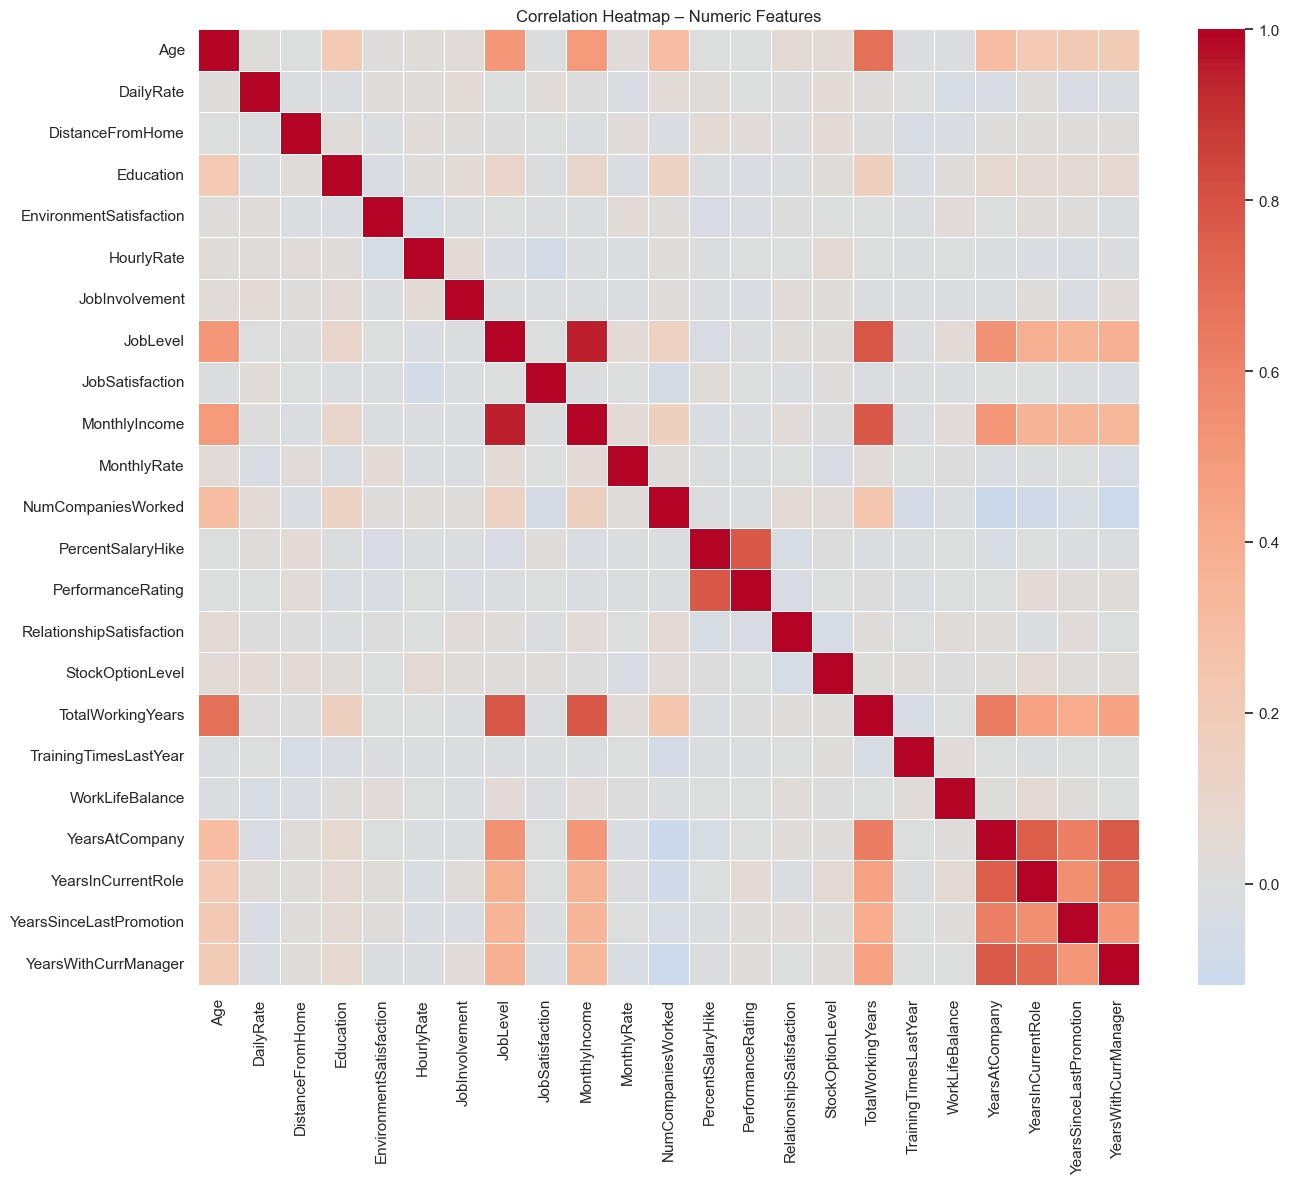

In [23]:
numeric_cols = df.select_dtypes(include=['number']).columns

corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, linewidths=0.5)
plt.title("Correlation Heatmap – Numeric Features")
plt.tight_layout()
plt.show()

### Correlation pairs

- Strong correlations between `JobLevel`, `MonthlyIncome`, and `TotalWorkingYears` reflect a predictable hierarchy: tenure drives advancement, which drives pay.  
- Similarly, `YearsAtCompany`, `YearsInCurrentRole`, and `YearsWithCurrManager` are linked, capturing overlapping aspects of employee longevity.
- The pairing of `PercentSalaryHike` and `PerformanceRating` suggests a structured, performance-tied raise system—potentially redundant in modeling.  

In [24]:
# Display top correlated feature pairs (absolute value > 0.7, no self-correlations)
high_corr_pairs = (
    corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)
high_corr_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation']
high_corr_pairs['AbsCorr'] = high_corr_pairs['Correlation'].abs()
high_corr_pairs = high_corr_pairs[high_corr_pairs['AbsCorr'] > 0.7].sort_values(by='AbsCorr', ascending=False)

print("Highly correlated numeric feature pairs (|corr| > 0.7):")
display(high_corr_pairs)

Highly correlated numeric feature pairs (|corr| > 0.7):


,Feature 1,Feature 2,Correlation,AbsCorr
134,JobLevel,MonthlyIncome,0.950300,0.950300
141,JobLevel,TotalWorkingYears,0.782208,0.782208
198,PercentSalaryHike,PerformanceRating,0.773550,0.773550
168,MonthlyIncome,TotalWorkingYears,0.772893,0.772893
249,YearsAtCompany,YearsWithCurrManager,0.769212,0.769212
247,YearsAtCompany,YearsInCurrentRole,0.758754,0.758754
251,YearsInCurrentRole,YearsWithCurrManager,0.714365,0.714365


# EDA Summary and Next Steps

### Key Insights from EDA:

- **Target imbalance**: 
  - Only ~16% of employees in the dataset have `Attrition = Yes`, indicating significant class imbalance. Future modeling should use metrics like ROC-AUC or recall instead of just accuracy.
- **Strong predictors identified**:
  - Employees who work **OverTime** are nearly 3× more likely to leave.
  - **Low JobSatisfaction**, **shorter tenure** (`YearsAtCompany`), and **low WorkLifeBalance** are also associated with higher attrition.
  - **Younger employees**, **low income**, those with a longer commute (`DistanceFromHome`) and those in certain **JobRoles** (Sales, Laboratory Technician, ...) appear to be more likely to leave.
- **Feature quality**:
  - No missing values or duplicates detected.
  - All columns passed structure validation.
  - `EmployeeCount`, `StandardHours`, and `Over18` show no variance and were dropped, along with the identifying column.
  - No negative or illogical values in numeric fields.
- **Correlation observations**:
  - Strong correlations cluster around compensation and tenure. 
  - Satisfaction, engagement, and location-related variables remain largely independent, offering distinct, potentially valuable signals for modeling attrition.

### Next Steps:

1. **Encode categorical variables** appropriately for modeling.
2. **Scale numeric features** if using distance-based or linear models.
3. **Stratify training/test split** to preserve class imbalance.
4. **Prepare data for model interpretability**.

The dataset appears clean and predictive, with several features that are both statistically and intuitively linked to attrition.
